In [1]:
import math
import json
import warnings
import numpy as np
import pandas as pd
import csv
import copy
import matplotlib.pyplot as plt

from collections import OrderedDict
from IPython.display import display, HTML

from cryptorandom.cryptorandom import SHA256, int_from_hash
from cryptorandom.sample import sample_by_index

from Audit import Audit, Assertion, Assorter, Contest, CVR, Stratum
from NonnegMean import NonnegMean
from Dominion import Dominion
from Hart import Hart

In [2]:
audit = Audit.from_dict({
         'seed':           12345678901234567890,
         'sim_seed':       314159265,
         #'cvr_file':       '/Users/amanda/Downloads/cvrs.zip', 
         'cvr_file':       '/Users/Jake/Desktop/OC CVRs/2022/cvrs.zip', 
         #'manifest_file':  'Data/OC_mock_manifest_detailed.xlsx',
         'manifest_file': 'Data/OC_nov22_full_manifest.xlsx',
         #'manifest_file': 'tests/Data/Hart_manifest.xlsx',
         'sample_file':    '',
         'mvr_file':       '',
         'log_file':       'Data/OC_example_log.json',
         'quantile':       0.8,
         'error_rate_1': 0,
         'error_rate_2': 0,
         #'error_rate_1':   0.001,
         #'error_rate_2':   0.0001,
         'reps':           100,
         'strata':         {'stratum_1': {'max_cards':   1989416, 
                                          'use_style':   False,
                                          'replacement': False,
                                          'audit_type':  Audit.AUDIT_TYPE.BALLOT_COMPARISON,
                                          'test':        NonnegMean.alpha_mart,
                                          'estimator':   NonnegMean.optimal_comparison,
                                          'test_kwargs': {}
                                         }
                           }
        })

# find upper bound on total cards across strata
audit.max_cards = np.sum([s.max_cards for s in audit.strata.values()])

In [3]:
%%time
cvr_list = Hart.read_cvrs_zip(audit.cvr_file)

CPU times: user 11min 59s, sys: 12.8 s, total: 12min 12s
Wall time: 12min 14s


In [4]:
len(cvr_list) # Number of cards = 1989416

1989416

In [5]:
votes = CVR.tabulate_votes(cvr_list)
styles = CVR.tabulate_styles(cvr_list)
cards = CVR.tabulate_cards_contests(cvr_list)

In [7]:
# Number of cards for each contest
# NOTE: based on counts for propositions there were 988086 ballots cast
# But based on election archives website there were 994227 ballots cast
cards 

defaultdict(int,
            {'SOUTH ORANGE COUNTY COMMUNITY COLLEGE DISTRICT\nGoverning Board Member, Trustee Area 4': 66009,
             'CAPISTRANO UNIFIED SCHOOL DISTRICT\nGoverning Board Member, Trustee Area 2, Short Term': 27577,
             'CAPISTRANO UNIFIED SCHOOL DISTRICT\nGoverning Board Member, Trustee Area 7': 25024,
             'County Supervisor\n5th District': 265928,
             'Proposition 1': 994327,
             'Proposition 26': 994327,
             'Proposition 27': 994327,
             'Proposition 28': 994327,
             'Proposition 29': 994326,
             'Proposition 30': 994326,
             'Proposition 31': 994326,
             'COAST COMMUNITY COLLEGE DISTRICT\nGoverning Board Member, Trustee Area 1': 52591,
             'CITY OF SEAL BEACH\nMember, City Council, District 3': 2339,
             'PLACENTIA-YORBA LINDA UNIFIED SCHOOL DISTRICT\nGoverning Board Member, Trustee Area 5': 13070,
             'County Supervisor\n4th District': 152143,
 

In [8]:
## Code to create manifest based on CVRs given
# Create manifest_dict to store batch name and number of ballots
# manifest_dict = {}
# for i in range(len(cvr_list)):
#     cvr_id = cvr_list[i].id
#     # CVR id has format (batch number)_(sheet)
#     batch, card_num = cvr_id.split("_")
#     # check if batch already in dict
#     if batch in manifest_dict.keys():
#         # if so add one to existing ballot count
#         manifest_dict[batch] = manifest_dict[batch] + 1
#     else:
#         # otherwise create key with value one
#         manifest_dict[batch] = 1
# # Convert dict info into dataframe
# manifest = pd.DataFrame({'Batch Name' : manifest_dict.keys(),
#              'Number of Ballots' : manifest_dict.values(),
#              'Container' : 1, 
#              'Tabulator' : 99808})
# manifest['cum_cards'] = np.array(np.cumsum(manifest['Number of Ballots']))
# write csv
# manifest.to_excel('Data/OC_nov22_full_manifest.xlsx', index=False)

In [9]:
#make dict of all contests in CVRs
contests = Contest.from_cvr_list(audit, votes, cards, cvr_list)

In [10]:
# Create array of vote for 2 contests TO DO
## Data from https://ocvote.gov/data/election-results-archives
vote_for_two = [
    'CITY OF ALISO VIEJO\nMember, City Council',
    'CITY OF IRVINE\nMember, City Council',
    'CITY OF LAGUNA NIGUEL\nMember, City Council',
    'CITY OF LAGUNA WOODS\nMember, City Council',
    'CITY OF LA HABRA\nMember, City Council, Full Term',
    'CITY OF LA PALMA\nMember, City Council',
    'CITY OF YORBA LINDA\nMember, City Council',
    'ROSSMOOR COMMUNITY SERVICES DISTRICT\nDirector'
               ]
# Create array of vote for 3 contests TO DO
vote_for_three = [
    'YORBA LINDA WATER DISTRICT\nDirector',
    'MOULTON NIGUEL WATER DISTRICT\nDirector',
    'MIDWAY CITY SANITARY DISTRICT\nDirector',
    'CITY OF LAGUNA HILLS\nMember, City Council, Full Term',
    'CITY OF FOUNTAIN VALLEY\nMember, City Council',
    'CITY OF CYPRESS\nMember, City Council',
    'HUNTINGTON BEACH UNION HIGH SCHOOL DISTRICT\nGoverning Board Member',
    'FOUNTAIN VALLEY SCHOOL DISTRICT\nGoverning Board Member',
    'LA HABRA CITY SCHOOL DISTRICT\nGoverning Board Member',
    'OCEAN VIEW SCHOOL DISTRICT\nGoverning Board Member',
    'CITY OF BREA\nMember, City Council',
    'CITY OF LAGUNA BEACH\nMember, City Council',
    'RANCHO SANTA MARGARITA\nMember, City Council',
    'CITY OF SAN CLEMENTE\nMember, City Council',
    'CITY OF VILLA PARK\nMember, City Council',
    'SILVERADO-MODJESKA RECREATION AND PARK DISTRICT\nDirector'
                 ]
# Update dictionary with correct n_winners
for con in vote_for_two:
    contests[con].n_winners = 2
    
for con in vote_for_three:
    contests[con].n_winners = 3

contests['CITY OF HUNTINGTON BEACH\nMember, City Council'].n_winners = 4 
# TO DO: UPDATE WINNERS FOR THESE CONTESTS

In [11]:
contests['CITY OF ALISO VIEJO\nMember, City Council'].winner = ['TIFFANY ACKLEY','MAX DUNCAN']
contests['CITY OF IRVINE\nMember, City Council'].winner = ['LARRY AGRAN','KATHLEEN TRESEDER']
contests['CITY OF LAGUNA NIGUEL\nMember, City Council'].winner = ['STEPHANIE ODDO','RAY GENNAWEY']
contests['CITY OF LAGUNA WOODS\nMember, City Council'].winner = ['CAROL MOORE','ANNIE MCCARY']
contests['CITY OF LA HABRA\nMember, City Council, Full Term'].winner = ['JOSE MEDRANO','JAMES "JIM" GOMEZ']
contests['CITY OF LA PALMA\nMember, City Council'].winner = ['NITESH PATEL','JANET K. CONKLIN']
contests['CITY OF YORBA LINDA\nMember, City Council'].winner = ['CARLOS RODRIGUEZ','JANICE LIM']
contests['ROSSMOOR COMMUNITY SERVICES DISTRICT\nDirector'].winner = ['MICHAEL MAYNARD','JO SHADE']

contests['YORBA LINDA WATER DISTRICT\nDirector'].winner = ['PHILLIP (PHIL) D. HAWKINS','THOMAS LINDSEY','BRETT R. BARBRE']
contests['MOULTON NIGUEL WATER DISTRICT\nDirector'].winner = ['DIANE RIFKIN', 'WILLIAM "BILL" MOORHEAD', 'DONALD R. FROELICH']
contests['MIDWAY CITY SANITARY DISTRICT\nDirector'].winner = ['ANDREW NGUYEN','SERGIO CONTRERAS','MARK NGUYEN']
contests['SILVERADO-MODJESKA RECREATION AND PARK DISTRICT\nDirector'].winner = ['LAURIE MARTZ','BRITTNEY KUHN','TED WRIGHT']
contests['CITY OF VILLA PARK\nMember, City Council'].winner = ['CRYSTAL K. MILES','NICOL JONES','JORDAN WU']
contests['CITY OF SAN CLEMENTE\nMember, City Council'].winner = ['VICTOR CABRAL','MARK ENMEIER','STEVEN "STEVE" KNOBLOCK']
contests['RANCHO SANTA MARGARITA\nMember, City Council'].winner = ['ANNE FIGUEROA', 'BRAD MCGIRR', 'JERRY HOLLOWAY']
contests['CITY OF LAGUNA HILLS\nMember, City Council, Full Term'].winner = ['ERICA PEZOLD', 'DAVID WHEELER','JOSHUA SWEENEY']
contests['CITY OF LAGUNA BEACH\nMember, City Council'].winner = ['ALEX ROUNAGHI','SUE KEMPF','MARK S. ORGILL']
contests['CITY OF FOUNTAIN VALLEY\nMember, City Council'].winner = ['JIM CUNNEEN','KIM CONSTANTINE','PATRICK HARPER']
contests['CITY OF CYPRESS\nMember, City Council'].winner = ['DAVID BURKE','SCOTT MINIKUS','BONNIE PEAT']
contests['CITY OF BREA\nMember, City Council'].winner = ['STEVEN C. VARGAS','BLAIR STEWART','CECILIA HUPP']
contests['HUNTINGTON BEACH UNION HIGH SCHOOL DISTRICT\nGoverning Board Member'].winner = ['DUANE DISHNO', 'BONNIE CASTREY', 'DIANA LEE CAREY']
contests['FOUNTAIN VALLEY SCHOOL DISTRICT\nGoverning Board Member'].winner = ['SANDRA CRANDALL', 'DENNIS COLE', 'PHU NGUYEN']
contests['LA HABRA CITY SCHOOL DISTRICT\nGoverning Board Member'].winner = ['ADAM ROGERS','CYNTHIA AGUIRRE','EMILY PRUITT']
contests['OCEAN VIEW SCHOOL DISTRICT\nGoverning Board Member'].winner = ['PATRICIA SINGER','JACK SOUDERS','MORGAN WESTMORELAND']

contests['CITY OF HUNTINGTON BEACH\nMember, City Council'].winner = ['PAT BURNS','TONY STRICKLAND','GRACEY VAN DER MARK','CASEY MCKEON']

In [12]:
# construct the dict of dicts of assertions for each contest
Assertion.make_all_assertions(contests)

True

In [13]:
audit.check_audit_parameters(contests)

## Read the ballot manifest

In [14]:
# special for Primary/Dominion manifest format
manifest = pd.read_excel(audit.manifest_file)

In [15]:
manifest.head()

,Batch Name,Number of Ballots,Container,Tabulator,cum_cards
0,0,316964,1,99808,316964
1,374,1357,1,99808,318321
2,132,5410,1,99808,323731
3,154,5310,1,99808,329041
4,71,5473,1,99808,334514


In [16]:
# check whether the manifest accounts for every card
audit.max_cards, np.sum(manifest['Number of Ballots'].astype(int))

(1989416, 1989416)

In [17]:
# Check that there is a card in the manifest for every card (possibly) cast. If not, add phantoms.
manifest, manifest_cards, phantom_cards = Hart.prep_manifest(manifest, audit.max_cards, len(cvr_list))

In [18]:
audit.max_cards, np.sum(manifest['Number of Ballots'].astype(int))

(1989416, 1989416)

In [19]:
cvr_list, phantom_vrs = CVR.make_phantoms(audit=audit, contests=contests, 
                                          cvr_list=cvr_list, prefix='phantom-1-')
print(f"Created {phantom_vrs} phantom records")

Created 0 phantom records


In [20]:
%%time
min_margin = Assertion.set_all_margins_from_cvrs(audit=audit, contests=contests, 
                                                 cvr_list=cvr_list)

print(f'minimum assorter margin {min_margin}')
Contest.print_margins(contests)

minimum assorter margin 2.0106403084696467e-06
margins in contest Proposition 1:
	assertion Yes v No: 0.06928616237126883
margins in contest Proposition 26:
	assertion No v Yes: 0.1811285321923619
margins in contest Proposition 27:
	assertion No v Yes: 0.30153472174748774
margins in contest Proposition 28:
	assertion Yes v No: 0.06358599709663548
margins in contest Proposition 29:
	assertion No v Yes: 0.19840294840294836
margins in contest Proposition 30:
	assertion No v Yes: 0.13289578449152928
margins in contest Proposition 31:
	assertion Yes v No: 0.0767959039235635
margins in contest COAST COMMUNITY COLLEGE DISTRICT
Governing Board Member, Trustee Area 1:
	assertion JIM MORENO v RUSSELL A. NEAL II: 0.004559629559629519
	assertion JIM MORENO v WRITE_IN: 0.012360913956658726
margins in contest CITY OF SEAL BEACH
Member, City Council, District 3:
	assertion STEPHANIE WADE v FRED MACKSOUD: 0.0003563859946837944
	assertion STEPHANIE WADE v LISA LANDAU: 2.7646304242123776e-05
	assertion 

In [21]:
audit.write_audit_parameters(contests=contests) 

In [22]:
%%time
sample_size = audit.find_sample_size(contests, cvrs=cvr_list)  
print(f'{sample_size=}\n{[(i, c.sample_size) for i, c in contests.items()]}')

sample_size=1989415
[('Proposition 1', 86), ('Proposition 26', 32), ('Proposition 27', 19), ('Proposition 28', 94), ('Proposition 29', 29), ('Proposition 30', 44), ('Proposition 31', 77), ('COAST COMMUNITY COLLEGE DISTRICT\nGoverning Board Member, Trustee Area 1', 1373), ('CITY OF SEAL BEACH\nMember, City Council, District 3', 1989390), ('PLACENTIA-YORBA LINDA UNIFIED SCHOOL DISTRICT\nGoverning Board Member, Trustee Area 5', 21202), ('CITY OF PLACENTIA\nMember, City Council, District 2', 1988728), ('CITY OF PLACENTIA\nCity Clerk', 1000), ('HUNTINGTON BEACH UNION HIGH SCHOOL DISTRICT\nGoverning Board Member', 1149), ('CITY OF HUNTINGTON BEACH\nMember, City Council', 1040), ('CITY OF HUNTINGTON BEACH\nCity Attorney', 634), ('L-City of Huntington Beach', 1003), ('M-City of Huntington Beach', 744), ('N-City of Huntington Beach', 1385), ('O-City of Huntington Beach', 1723), ('FULLERTON JOINT UNION HIGH SCHOOL DISTRICT\nGoverning Board Member, Trustee Area 4', 5934), ('County Supervisor\n4th

In [72]:
print(contests['Proposition 1'])

{'id': 'Proposition 1', 'name': 'Proposition 1', 'risk_limit': 0.05, 'cards': 994327, 'choice_function': 'PLURALITY', 'n_winners': 1, 'share_to_win': None, 'candidates': ['Yes', 'No'], 'winner': ['Yes'], 'assertion_file': None, 'audit_type': 'BALLOT_COMPARISON', 'test': <function NonnegMean.alpha_mart at 0x7fc240b11790>, 'g': 0.1, 'estim': <function NonnegMean.optimal_comparison at 0x7fc240b11b80>, 'use_style': True, 'assertions': {'Yes v No': <Audit.Assertion object at 0x7fc280a4d7c0>}, 'tally': None, 'sample_size': 42, 'cvrs': 994327, 'margins': {'Yes v No': 0.13862542201911454}}


In [73]:
contest_names = []
contest_cards = []
contest_sample_sizes = []
sampling_fractions = []
margins = []
for c in contests:
    contest_names.append(c)
    contest_cards.append(contests[c].cards)
    contest_sample_sizes.append(contests[c].sample_size)
    sampling_fractions.append(contests[c].sample_size / contests[c].cards)

In [68]:
sorted(zip(contest_sample_sizes, contest_names), reverse = True)[0:10]

[(21772, 'FOUNTAIN VALLEY SCHOOL DISTRICT\nGoverning Board Member'),
 (11354, 'K-City of Costa Mesa'),
 (7999, 'CITY OF SAN CLEMENTE\nMember, City Council'),
 (2715, 'CITY OF VILLA PARK\nMember, City Council'),
 (2634, 'OCEAN VIEW SCHOOL DISTRICT\nGoverning Board Member'),
 (2088,
  'ORANGE UNIFIED SCHOOL DISTRICT\nGoverning Board Member, Trustee Area 4'),
 (2064, 'CITY OF WESTMINSTER\nMember, City Council, District 1'),
 (1738, 'LA HABRA CITY SCHOOL DISTRICT\nGoverning Board Member'),
 (897, 'ROSSMOOR COMMUNITY SERVICES DISTRICT\nDirector'),
 (873, 'MEMBER OF THE STATE ASSEMBLY\n71st District')]

Text(0.5, 1.0, 'With Style')

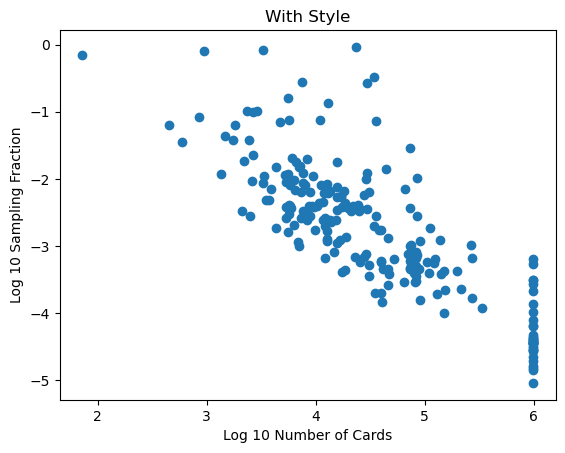

In [76]:
plt.scatter(np.log10(contest_cards), np.log10(sampling_fractions))
plt.xlabel("Log 10 Number of Cards")
plt.ylabel("Log 10 Sampling Fraction")
plt.title("With Style")

In [58]:
# Check for style overlap
for style in styles:
    if 'FOUNTAIN VALLEY SCHOOL DISTRICT\nGoverning Board Member' in style and 'K-City of Costa Mesa' in style:
        print(style)

In [60]:
# Check for style overlap
for style in styles:
    if 'K-City of Costa Mesa' in style and 'CITY OF SAN CLEMENTE\nMember, City Council' in style:
        print(style)

In [41]:
%%time
prng = SHA256(audit.seed)
CVR.assign_sample_nums(cvr_list, prng)
sampled_cvr_indices = CVR.consistent_sampling(cvr_list=cvr_list, contests=contests)
n_sampled_phantoms = np.sum(sampled_cvr_indices > manifest_cards)
print(f'The sample includes {n_sampled_phantoms} phantom cards.')

TypeError: '<' not supported between instances of 'int' and 'NoneType'

In [42]:
cards_to_retrieve, sample_order, cvr_sample, mvr_phantoms_sample = \
    Hart.sample_from_cvrs(cvr_list, manifest, sampled_cvr_indices)

NameError: name 'sampled_cvr_indices' is not defined

In [ ]:
mvr_sample = cvr_sample
CVR.prep_comparison_sample(mvr_sample, cvr_sample, sample_order)

In [ ]:
%%time
p_max = Assertion.set_p_values(contests=contests, mvr_sample=mvr_sample, cvr_sample=cvr_sample)
print(f'maximum assertion p-value {p_max}')
done = audit.summarize_status(contests)